# PosEmotion

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import tools.davinci as dv
import tools.metrics as ms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tools.detector import YoloDetector, MoveNetDetector, PoseLandmarkerDetector
from tools.extractor import Extractor
from tools.structures import Skeleton

## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0


Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

# Uncomment the line below to extract frames from the videos
# extractor.extract_frames()

### Data Augmentation

Data augmentation will help to increase the dataset in size, adding robustness and improvng the accuracy of the model. For data augmentation, the following techniques will be applied for each image:
- Vertical flipping
- Horizontal flipping
- Random rotations (from 30 to 330 degrees)

In [4]:
# extractor.flip_frames(target="assets/frames_vflip", axis=0)
# extractor.flip_frames(target="assets/frames_hflip", axis=1)
# extractor.random_rotate_frames(target="assets/frames_rotated", minr=30, maxr=330)

### Skeleton Joints Extraction

To extract keypoints, different approaches will be used such as YOLO-Pose, DeepPose and OpenPose. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

#### YOLO-Pose

In [9]:
yolo_detector = YoloDetector("models/yolov8x-pose-p6.pt")

def apply_yolo(df, target, output_csv):
    keypoints = yolo_detector.detect_multi(df, target)
    yolo_df = pd.concat(keypoints, ignore_index=True)
    yolo_df.to_csv(output_csv, index=False)

# Uncomment the lines below to apply YOLO to the frames
# apply_yolo(
#     df,
#     "assets/frames",
#     "assets/annotations/keypoints_yolo.csv"
# )

yolo_df = pd.read_csv("assets/annotations/keypoints_yolo.csv")
yolo_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,803.315979,173.557571,835.515747,148.530548,783.055054,145.369812,879.411865,173.806686,757.570801,163.862640,...,695.001770,688.964600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,804.176758,173.216003,835.653809,147.682251,782.198486,145.796295,878.665039,173.041428,754.971069,165.978302,...,691.973938,694.487122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,805.239990,169.009888,836.457214,143.686768,782.505249,142.022675,877.768127,170.935852,753.729370,164.452728,...,695.380554,695.014038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,805.590393,172.032562,835.968811,146.862885,780.613586,146.146515,877.941833,173.451324,752.341492,171.449234,...,690.252319,686.663513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,787.117676,165.914810,817.990356,138.446503,763.025269,141.949539,868.388611,162.747101,740.108887,168.018570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### MoveNet

In [10]:
movenet_detector = MoveNetDetector("lightning")

def apply_movenet(df, target, output_csv):
    keypoints = movenet_detector.detect_multi(df, target)
    movenet_df = pd.concat(keypoints, axis=1, ignore_index=True).T
    movenet_df.to_csv(output_csv, index=False)

# Uncomment lines below to apply MoveNet detector to the frames
# apply_movenet(
#     df,
#     "assets/frames",
#     "assets/annotations/keypoints_movenet.csv"
# )

movenet_df = pd.read_csv("assets/annotations/keypoints_movenet.csv")
movenet_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,798.434601,171.788353,839.572601,151.494362,768.469696,147.664694,883.934555,177.981251,744.240112,170.097048,...,683.769531,638.729110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,799.262924,171.033987,841.061096,151.012831,768.369904,146.848648,885.828857,178.007441,743.087616,169.363668,...,681.658630,655.905590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,797.994690,164.389780,839.317856,145.981822,767.926254,143.066486,881.477203,173.334593,741.144257,165.809784,...,684.390564,645.246878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,797.490158,171.685259,836.839981,149.894757,767.027588,148.734777,879.818954,173.152846,739.764557,170.265276,...,680.073471,651.498442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,786.974945,166.934295,826.663437,144.017833,755.357513,143.959157,874.286728,166.885672,728.797226,164.895709,...,683.938217,622.532558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### PoseLandmarker (with depth)

In [16]:
poselandmarker_detector = PoseLandmarkerDetector("models/pose_landmarker_full.task")

def apply_plm(df, target, output_csv):
    keypoints = poselandmarker_detector.detect_multi(df, target)
    poselandmarker_df = pd.concat(keypoints, axis=1, ignore_index=True).T
    poselandmarker_df.to_csv(output_csv, index=False)

# Uncomment lines below to apply MoveNet detector to the frames
# apply_plm(
#     df,
#     "assets/frames",
#     "assets/annotations/keypoints_plm.csv"
# )

poselandmarker_df = pd.read_csv("assets/annotations/keypoints_plm.csv")
poselandmarker_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,269.080724,140.505557,302.292257,116.055662,245.329291,113.157534,331.327906,138.853607,232.171312,132.276988,...,192.321224,661.971808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,278.515550,142.537466,308.969119,119.705292,257.802978,116.660051,340.322865,141.584580,241.561382,131.470972,...,210.340474,663.460505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,284.454120,136.837065,314.959585,115.588630,262.920175,111.256520,345.827073,137.698243,244.183326,126.791058,...,214.881144,667.064608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,290.010561,136.184586,317.347729,116.137694,266.370901,114.463834,344.740868,133.066662,246.370455,130.625688,...,204.456865,662.161523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,285.641086,135.585562,314.917994,111.125870,262.942587,111.411479,343.586366,130.106380,253.174025,132.797068,...,208.663934,650.567144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Joints:
Image: assets/frames_rotated/aJKL0ahn1Dk_0.jpg
Nose: [135.05747497081757, 477.5266990661621]
Left Eye: [94.1278824210167, 468.7396342754364]
Right Eye: [129.3834689259529, 512.7478036880493]
Left Ear: [93.65933954715729, 433.41877365112305]
Right Ear: [154.57813024520874, 511.88804841041565]
Left Shoulder: [179.86664831638336, 274.54823410511017]
Right Shoulder: [315.6581389904022, 455.90110993385315]
Left Elbow: [281.04884058237076, 42.08230742812157]
Right Elbow: [524.9883648753166, 397.52612495422363]
Left Wrist: [353.0507093667984, 203.20037531852722]
Right Wrist: [466.9159898161888, 427.77113676071167]
Left Hip: [495.33805042505264, 108.55357533693314]
Right Hip: [580.3465723991394, 220.70493179559708]
Left Knee: [nan, nan]
Right Knee: [nan, nan]
Left Ankle: [nan, nan]
Right Ankle: [nan, nan]


I0000 00:00:1718216221.490398 1762348 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
W0000 00:00:1718216221.567320 1974922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718216221.571772 1974931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


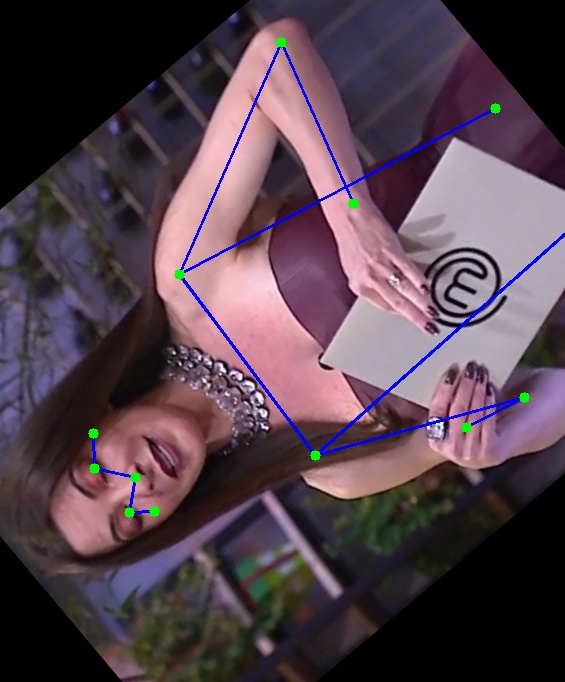

In [20]:
# Example of how a skeleton looks like
result, depths = poselandmarker_detector.detect("assets/frames_rotated/aJKL0ahn1Dk_0.jpg")
print(result)
dv.draw(result, inline=True)

#### Combine all DataFrames (for PoseLandmarker)

In [13]:
initial_df = pd.read_csv("assets/annotations/annotations.csv")
print("initial_df shape:", initial_df.shape)

yolo_df = pd.read_csv("assets/annotations/keypoints_yolo.csv")
yolo_merged = pd.concat([initial_df, yolo_df], axis=1)
print("yolo_merged shape:", yolo_merged.shape)

movenet_df = pd.read_csv("assets/annotations/keypoints_movenet.csv")
movenet_merged = pd.concat([initial_df, movenet_df], axis=1)
print("movenet_merged shape:", movenet_merged.shape)

poselandmarker_df = pd.read_csv("assets/annotations/keypoints_plm.csv")
poselandmarker_merged = pd.concat([initial_df, poselandmarker_df], axis=1)
print("poselandmarker_merged shape:", poselandmarker_merged.shape)

# combined_df = pd.concat([yolo_merged, movenet_merged, poselandmarker_merged], axis=0).reset_index(drop=True)
combined_df = pd.concat([poselandmarker_merged], axis=0).reset_index(drop=True)
print("combined_df shape:", combined_df.shape)
combined_df.head()

initial_df shape: (8087, 9)
yolo_merged shape: (8087, 43)
movenet_merged shape: (8087, 43)
poselandmarker_merged shape: (8087, 43)
combined_df shape: (8087, 43)


,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,811.567688,...,735.863647,680.167909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,808.694992,...,742.006912,672.522197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,810.958405,...,731.772079,688.078923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,810.573959,...,741.304703,666.833124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0,793.814240,...,760.392303,635.200481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalization

#### Skeleton Normalization

At first, not all skeletons, detected on the images, have consistent position relative to the camera. Some people stand and look directly to the camera, some tilted by some unknown angle $\alpha$ around $y$-axis, so only their projection is seen on $xz$ plane; others may stand with their back. For that purpose, it may needed to rotate the skeletons around $y$-axis. However, because there is no depth information in 2D images and only $(x,y)$ coordinates given for skeleton, the <code>PoseLandmarker</code> will be used to estimate $z$ coordinate of each pixel on the image. In other words, the estimated $z$ coordinate will be transferred to the other results from other models. Then detected pixels will be aligned with existing joints coordinates and new Keypoints object with $(x,y,z)$ coordinates will be created as an output for each frame.

According to [Romero Moralis](https://openaccess.thecvf.com/content_CVPR_2019/html/Morais_Learning_Regularity_in_Skeleton_Trajectories_for_Anomaly_Detection_in_Videos_CVPR_2019_paper.html), in 2D image space, $xy$-coordinates alone poorly represent the real location in the scene because the depth is missing. However, the size of a skeleton’s bounding box is correlated with the skeleton’s depth in the scene. To bridge this gap, the skeleton's bounding box can be used (that in our case was already given in dataset) with parameters $f^g = (x^g, y^g, w, h)$ and used to normalize the local components $f^{l,i} = (x^{l,i}, y^{l,i})$. 

In [14]:
norm_skeletons = []

for index, row in combined_df.iterrows():
    start_label = "nose_X"
    row_truncated = row.loc[start_label:]
    box = (row["X"], row["Y"], row["Width"], row["Height"])
    skeleton = Skeleton.from_series(row_truncated)
    norm_skeleton = ms.normalize_skeleton(skeleton, box)
    norm_skeletons.append(norm_skeleton.to_series())

norm_skeletons_df = pd.concat(norm_skeletons, axis=1).T
norm_skeletons_df.shape

# initial_dfs = pd.concat([initial_df] * 3, axis=0).reset_index(drop=True)
initial_dfs = pd.concat([initial_df], axis=0).reset_index(drop=True)
norm_combined_df = pd.concat([initial_dfs, norm_skeletons_df], axis=1)
print(norm_combined_df.shape)
norm_combined_df.head()

(8087, 43)


,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,17.405130,...,15.693027,7.123160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,17.349217,...,15.841016,7.042496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,17.409460,...,15.618603,7.206577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,17.409820,...,15.843244,6.982456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0,17.056057,...,16.300195,6.647347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data Cleaning

According to [Wei Tang](https://www.mdpi.com/1424-8220/22/11/4245), frames in which body parts were occluded or lost were excluded from further analysis, because the skeletons in these frames could not be detected correctly using the current 2D pose estimation algorithm. The necessary body parts will be determined as torso, left and right hands. The position of head and legs will be ommited.

In [13]:
# Remove all columns that represent legs
columns_drop = norm_combined_df.columns[norm_combined_df.columns.get_loc('right_hip_Y')+1:]
cleaned_df = norm_combined_df.drop(columns=columns_drop)

# Remove rows that have NaN values in all necessary body parts
body_parts = cleaned_df.columns[cleaned_df.columns.get_loc('right_ear_Y')+1:]
cleaned_df = cleaned_df.dropna(subset=body_parts, how='any')
cleaned_df = cleaned_df.reset_index(drop=True)

# For now, later will be changed to "all" and only for eyes and nose
cleaned_df = cleaned_df.dropna(subset=["nose_X", "nose_Y", "left_eye_X", "left_eye_Y",
                                       "right_eye_X", "right_eye_Y", "left_ear_X", "left_ear_Y",
                                       "right_ear_X", "right_ear_Y"], how='any')
cleaned_df = cleaned_df.reset_index(drop=True)

cleaned_df

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,right_elbow_X,right_elbow_Y,left_wrist_X,left_wrist_Y,right_wrist_X,right_wrist_Y,left_hip_X,left_hip_Y,right_hip_X,right_hip_Y
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,17.405130,...,12.976702,5.255042,19.080167,5.401737,12.810288,4.701707,18.776820,7.150437,15.693027,7.123160
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,17.349217,...,13.099148,5.101940,18.988949,5.592083,13.502386,4.833064,18.723041,7.113081,15.841016,7.042496
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,17.409460,...,13.030436,5.574276,19.306144,5.596356,13.087663,4.932753,18.778760,7.201062,15.618603,7.206577
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,17.409820,...,13.259038,5.066034,18.597723,5.566610,13.228309,5.027420,18.939889,6.996122,15.843244,6.982456
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0,17.056057,...,13.299996,4.893303,17.464459,5.198144,12.173875,4.576753,19.019764,6.746047,16.300195,6.647347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3583,ngITkMvWuq8,3,"[['Neutral'], 'No annotation', ['Sad']]",22213,53.531218,3.053565,35.005118,96.258387,1,25.870593,...,21.241694,6.150666,28.969074,6.970338,25.381609,7.500968,26.673676,7.357963,23.106377,7.583781
3584,ngITkMvWuq8,3,"[['Neutral'], 'No annotation', ['Sad']]",22219,53.531218,3.053565,35.005118,96.258387,1,25.989169,...,21.385825,6.097281,28.917944,7.081019,25.347234,7.526059,27.155616,7.369479,23.380219,7.613369
3585,ngITkMvWuq8,3,"[['Neutral'], 'No annotation', ['Sad']]",22225,53.531218,3.053565,35.005118,96.258387,1,26.090660,...,21.364597,6.073173,29.400350,6.904584,25.618225,7.402048,27.520176,7.237763,23.825253,7.536535
3586,ngITkMvWuq8,3,"[['Neutral'], 'No annotation', ['Sad']]",22231,53.531218,3.053565,35.005118,96.258387,1,26.277361,...,21.643554,6.105631,29.149373,7.005720,25.973930,7.429277,27.435083,7.294762,23.974140,7.540912


## Step 2: Feature Extraction

#### Segment Normalization

Before clustering, we needs to ensure that all segments have identical size:
- If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
- If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
- If the size of a segment $s = x$, then segment normalization won't be applied.

In [14]:
segments = ms.segmentate(cleaned_df)
print("Total number of segments:", len(segments))
print("Original (first 5):", [segment.indices() for segment in segments][:5])

norm_segments = [ms.normalize_segment(segment, 5) for segment in segments]
norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)

norm_segments = ms.segmentate(norm_df)
print("Total number of normalized segments:", len(norm_segments))
print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

Total number of segments: 348
Original (first 5): [(0, 49), (50, 56), (57, 65), (66, 74), (75, 88)]
Total number of normalized segments: 348
Normalized (first 5): [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24)]


### Curve Simplification

![Ramer-Douglas_Peucker algorithm visualization](media/rdp.gif)

To extract trajectory features, inspired by [Tomasz Sapiński](https://www.mdpi.com/1099-4300/21/7/646), the curve simplification (CS) algorithm, based on the [Ramer-Douglas-Peucker algorithm](https://rdp.readthedocs.io/en/latest/), will be applied, for 2D joints separately for each segment, that returns a set of key points that are essential for accurately representing the original curve. The algorithm will return the following:
 
- The critical frames in the motion sequence that capture significant changes in the movement.
- The simplified version of the original motion trajectory (data reduction).

The CS algorithm will be called before each feature extraction procedure.

In [15]:
segment = norm_segments[20]

#### Vector Features

Each movement of each joint can be represented as a vector with its own magnitude, direction and slope.

In [16]:
v_f = segment.get_vectors(["nose", "left_shoulder", "right_shoulder", 
                           "left_elbow", "right_elbow", "left_wrist", "right_wrist"])
v_f

{'Label': 'Sad',
 'Magnitude_nose_1': 4.039687351471948,
 'Direction_nose_1': -0.02974929095452025,
 'Slope_nose_1': -0.029758070304751718,
 'Magnitude_nose_2': 2.7191766283755756,
 'Direction_nose_2': 2.921327685590805,
 'Slope_nose_2': -0.22389765590599908,
 'Magnitude_nose_3': 0.8233262220202399,
 'Direction_nose_3': -0.2313048325490485,
 'Slope_nose_3': -0.23552015129928425,
 'Magnitude_nose_4': 1.426219099036605,
 'Direction_nose_4': 2.9304620093355465,
 'Slope_nose_4': -0.2143247388908934,
 'Magnitude_left_shoulder_1': 3.885260644885347,
 'Direction_left_shoulder_1': -0.050528371098724385,
 'Slope_left_shoulder_1': -0.05057141666177401,
 'Magnitude_left_shoulder_2': 3.5662765986414184,
 'Direction_left_shoulder_2': 3.0350023652728515,
 'Slope_left_shoulder_2': -0.10699580614743158,
 'Magnitude_left_shoulder_3': 0.9801971485722698,
 'Direction_left_shoulder_3': -0.2257324735280595,
 'Slope_left_shoulder_3': -0.22964634296928932,
 'Magnitude_left_shoulder_4': 0.688129866484649,
 'D

#### Emotion Labeling

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a particular emotion. In that case for each segment the number of each emotion will be calculated (e.g. <code>[[Happy, Sad, Happy], [Happy, Happy, Angry]]</code> will be converted to <code>{Happy: 4, Sad: 1, Angry: 1, Fear: 0, ...}</code>).

In [17]:
emotion_count = segment.count_emotions()

print("Emotion count:", emotion_count)

Emotion count: {'Happy': 0, 'Sad': 9, 'Fear': 4, 'Surprise': 0, 'Disgust': 0, 'Anger': 0, 'Neutral': 2}


## Step 3: Clustering

### Prepare data to cluster

In [18]:
features = {}
pairs = ["nose", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist"]

for i in range(len(norm_segments)):
    feature = norm_segments[i].get_vectors(pairs)
    features[f"s_{i}"] = feature

features_df = pd.DataFrame.from_dict(features, orient='index')
print(features_df.shape)
features_df.head()

(348, 85)


,Label,Magnitude_nose_1,Direction_nose_1,Slope_nose_1,Magnitude_nose_2,Direction_nose_2,Slope_nose_2,Magnitude_nose_3,Direction_nose_3,Slope_nose_3,...,Slope_right_wrist_1,Magnitude_right_wrist_2,Direction_right_wrist_2,Slope_right_wrist_2,Magnitude_right_wrist_3,Direction_right_wrist_3,Slope_right_wrist_3,Magnitude_right_wrist_4,Direction_right_wrist_4,Slope_right_wrist_4
s_0,Happy,1.130833,3.140175,-0.001418,1.451413,-0.065378,-0.065471,3.082190,3.111631,-0.029971,...,2.266440,2.536186,1.115195,2.040891,4.999766,-2.779708,0.378556,6.739447,0.218367,0.221905
s_1,Fear,0.272104,-2.805864,0.348938,1.627007,0.129969,0.130706,1.307756,0.025632,0.025638,...,-0.246433,0.605911,0.905835,1.275371,0.711000,-2.160622,1.494090,1.029836,-3.119454,0.022142
s_2,Happy,0.140037,-0.667210,-0.787723,2.117340,1.423039,6.718539,1.784249,-1.822327,3.891454,...,0.177555,5.002133,0.048755,0.048794,0.475395,-0.333829,-0.346808,0.533340,0.961485,1.432883
s_3,Neutral,0.282041,-2.991538,0.151191,0.829029,3.106873,-0.034733,0.605878,-0.040562,-0.040584,...,-0.091766,1.079891,-3.137487,0.004105,0.700559,-0.077057,-0.077210,4.358408,2.671114,-0.508568
s_4,Happy,0.539000,-0.056605,-0.056666,0.647876,2.983812,-0.159103,0.952111,-3.083251,0.058408,...,-0.931036,0.840536,3.026492,-0.115611,0.506889,3.080225,-0.061445,0.388984,-2.786811,0.370457


### Analyze the initial labels

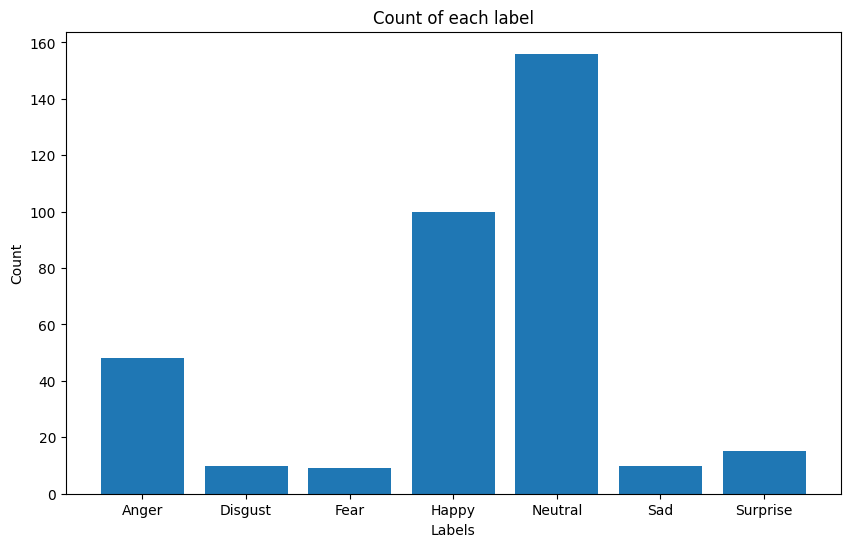

In [19]:
def plot_label_counts(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Count of each label')
    plt.show()

plot_label_counts(features_df["Label"])

### Hierarchical Clustering

In [39]:
data = features_df.drop(columns=['Label'])
data = data.fillna(data.mean())

cluster = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='average')
cluster_labels = cluster.fit_predict(data)

data['Cluster'] = cluster_labels

# Silhouette Score
silhouette_avg = silhouette_score(data, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(data, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin}')

# sns.pairplot(data, hue='Cluster', palette='rainbow')
# plt.show()

Silhouette Score: 0.8689092750919206
Davies-Bouldin Index: 0.19498798088217


Adjusted Rand Index: -0.010927996294260273
Normalized Mutual Information: 0.022549864881516092


<Axes: >

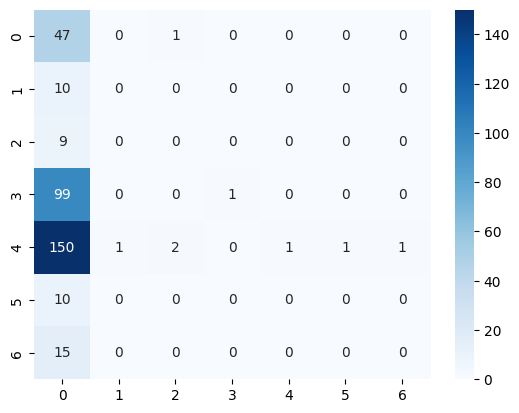

In [40]:
# Assuming features_df['Emotion'] contains the pre-defined clusters
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(features_df['Label'])

# Now, you can compare true_labels with cluster_labels
ari = metrics.adjusted_rand_score(true_labels, cluster_labels)
nmi = metrics.normalized_mutual_info_score(true_labels, cluster_labels)

print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information: {nmi}')

cm = confusion_matrix(true_labels, cluster_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

## Step 4: Classification

### Support Vector Machines (SVM)

According to [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/svm.html), SVM will be useful in classification problem in high dimensional spaces and still effective if number of dimensions is higher than number of samples. In addition, it is fast and memory efficient. Also, it can be used in datasets where each class is unequally represented by manually adjusting weights, suggested by [Hengtao Tantai](https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75).

X_train: (278, 85) X_test: (70, 85)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..

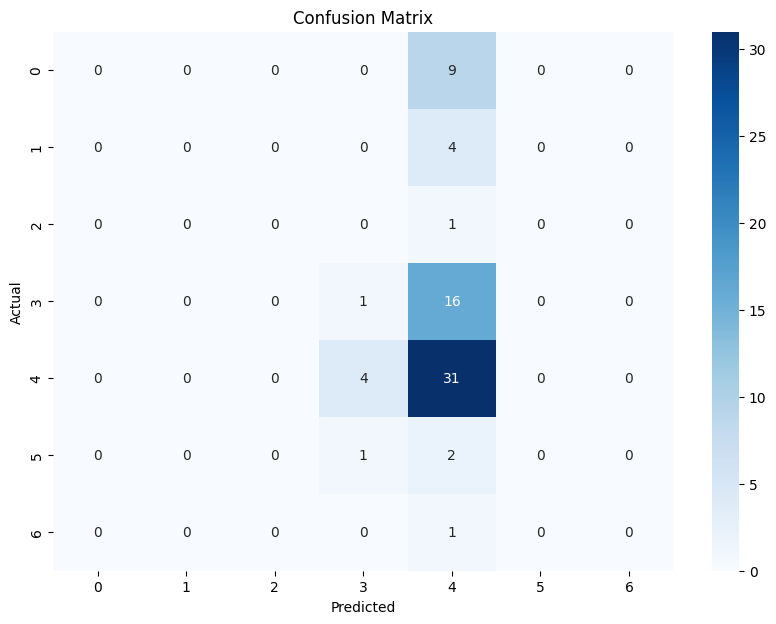

In [45]:
scaler = StandardScaler()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

X = features_df.drop(['Label'], axis=1)
y = features_df['Label']
labels = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(class_weight="balanced")  # use "balanced" taking into account the class imbalance
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_svm = SVC(**best_params)
best_svm.fit(X_train_scaled, y_train)
y_pred = best_svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()